# Linear pendulum system identification

Here, we define a linear pendulum system and estimate the discrete-time dynamics matrix using both a Bayesian methodology and the dynamic mode decomposition (DMD).

In [130]:
import torch
import bside
import matplotlib.pyplot as plt

#### Specify problem parameters

In [131]:
dt = 0.05 # data timestep
qc = 0.1 # process noise covariance parameter
g = 9.81 # gravity coefficient
T = 100 # number of data
xdim = 2
ydim = 2
r = 0.5
measure_y0 = False
t = torch.linspace(0, T*dt, T+1)

#### Define the system of interest

In [132]:
x0 = torch.tensor([1.5, 0.])
A_continuous = torch.tensor([[0., 1.], [-g, 0.]])
A = bside.Matrix(torch.linalg.matrix_exp(A_continuous * dt))
C = bside.Matrix(torch.tensor([[1., 0.], [0., 1.]]))
Q = bside.PSDMatrix(torch.tensor([[qc * dt**3 / 3, qc * dt**2 / 2], [qc * dt**2 / 2, qc * dt]]))
R = bside.PSDMatrix(torch.eye(2) * r**2)

dynamics = bside.LinearModel(A)
measurement = bside.LinearModel(C)
        
observation_model = bside.LinearGaussianModel(
    model = measurement,
    noise_cov = R
)

true_sys = bside.SSM(
    xdim = xdim,
    ydim = ydim,
    dynamics = dynamics,
    observations = observation_model
)

#### Generate and visualize data

In [133]:
x_true, y = true_sys.measure(x=x0, T=T, keep_y0=measure_y0, return_x=True)
data = bside.Data(y=y, u=None)

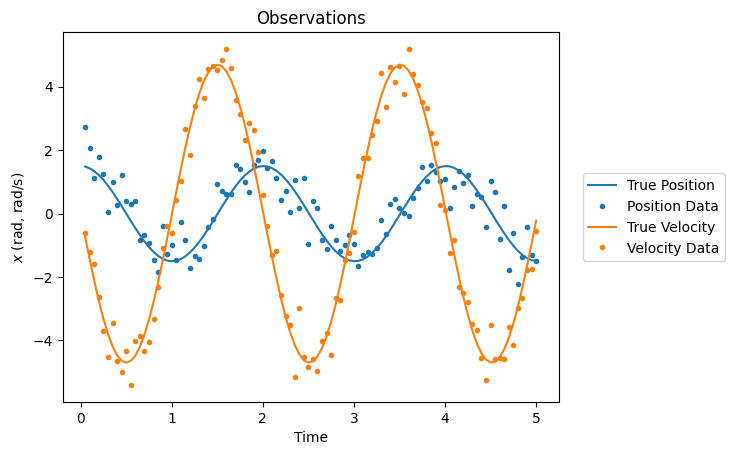

In [134]:
colors = ['tab:blue', 'tab:orange']
true_labels = ['True Position', 'True Velocity']
data_labels = ['Position Data', 'Velocity Data']
plt.figure()
for ii in range(ydim):
    plt.plot(t if measure_y0 else t[1:], x_true[:, ii], color=colors[ii], label=true_labels[ii])
    plt.plot(t if measure_y0 else t[1:], y[:, ii], '.', color=colors[ii], label=data_labels[ii])

plt.title('Observations')
plt.xlabel('Time')
plt.ylabel('$x$ (rad, rad/s)')
plt.legend(bbox_to_anchor=(1.35, 0.5), loc='center right')
plt.show()

## Estimate with the Bayesian methodology

In [135]:
A_model = bside.Matrix(
    default=torch.eye(xdim), 
    mask=torch.ones(xdim, xdim, dtype=bool), 
    indices=torch.arange(xdim**2)
)
learnable_dynamics = bside.LinearGaussianModel(
    model = bside.LinearModel(A_model),
    noise_cov = Q
)

bayes_sys = bside.SSM(
    xdim = xdim,
    ydim = ydim,
    dynamics = learnable_dynamics,
    observations = observation_model
)

P0 = bside.PSDMatrix(0.01 * torch.eye(xdim))
init_dist = bside.FilteringDistribution(x0, P0)
filter = bside.KalmanFilter(model=bayes_sys)

with torch.no_grad():
    initial_nlml = filter.nlog_marginal_likelihood(data, init_dist, measure_y0)

#### Define a class to perform the optimization

In [136]:
class SSM_Estimate(torch.nn.Module):

    def __init__(
        self,
        model: bside.SSM
    ):
        
        super().__init__()
        self.model = model
        self.filter = bside.KalmanFilter(model=model)

    def loss(
        self,
        data: bside.Data,
        init_dist: bside.FilteringDistribution,
        measure_y0: bool
    ) -> torch.Tensor:

        return self.filter.nlog_marginal_likelihood(data, init_dist, measure_y0)
    
    def optimize(
        self, 
        data: bside.Data, 
        init_dist: bside.FilteringDistribution, 
        measure_y0: bool, 
        lr: float = 0.01, 
        epochs: int = 100,
        verbose: bool = True
    ) -> None:
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            self.filter.model.update()
            loss = self.loss(data, init_dist, measure_y0)
            loss.backward()
            optimizer.step()
            if verbose:
                print(self.filter.model.dynamics.mat_x)
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



#### Optimize the system and check the result

In [137]:
ssm_estimate = SSM_Estimate(bayes_sys)
ssm_estimate.optimize(data, init_dist, measure_y0, lr=1e-2, epochs=200, verbose=False)
with torch.no_grad():
    final_nlml = ssm_estimate.loss(data, init_dist, measure_y0)

print(f'Estimated A matrix:\n{A_model.val}')
print(f'True A matrix:\n{A.val}')
print(f'Initial negative log marginal likelihood: {initial_nlml.item()}')
print(f'Final negative log marginal likelihood: {final_nlml.item()}')

Estimated A matrix:
tensor([[ 0.9795,  0.0460],
        [-0.5247,  0.9945]], grad_fn=<IndexPutBackward0>)
True A matrix:
tensor([[ 0.9878,  0.0498],
        [-0.4885,  0.9878]])
Initial negative log marginal likelihood: 1539.8701171875
Final negative log marginal likelihood: 154.53688049316406


#### Generate and visualize the predictions of the optimized model

In [138]:
with torch.no_grad():
    y_bayes = bayes_sys.predict(
        x = x0,
        u = None,
        T = T,
        return_x = False,
        keep_y0 = True
    )

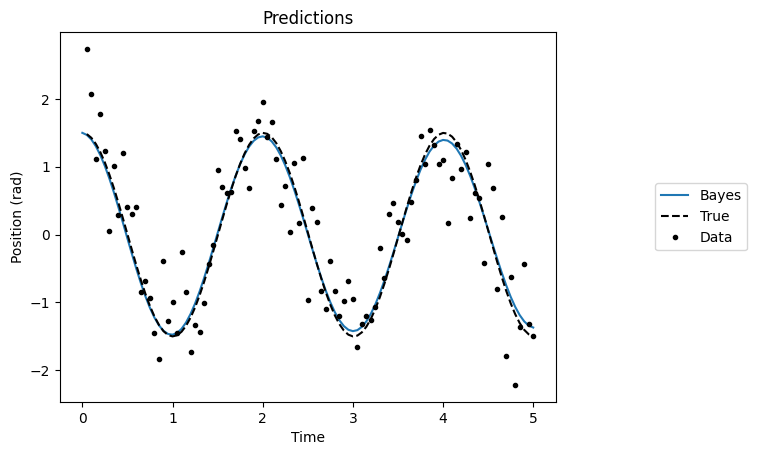

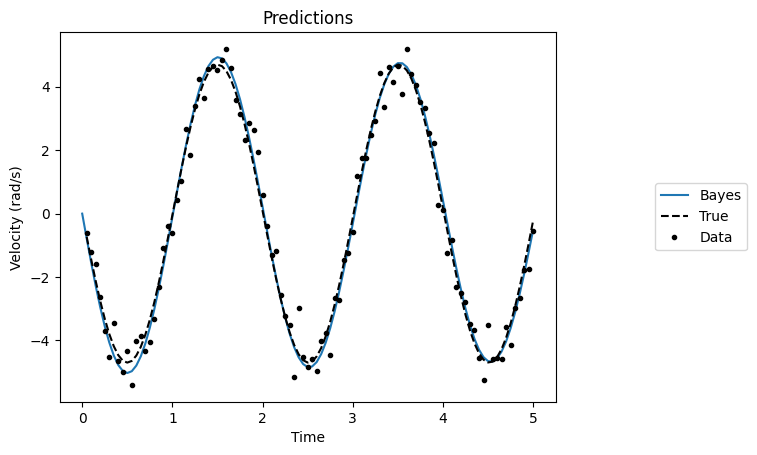

In [139]:
ylabels = ['Position (rad)', 'Velocity (rad/s)']
for ii in range(xdim):
    plt.figure()
    plt.plot(t, y_bayes[:, ii], label='Bayes')
    plt.plot(t if measure_y0 else t[1:], x_true[:, ii], 'k--', label='True')
    plt.plot(t if measure_y0 else t[1:], y[:, ii], 'k.', label='Data')
    plt.title('Predictions')
    plt.xlabel('Time')
    plt.ylabel(ylabels[ii])
    plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center right')
plt.show()

## Estimate with DMD

#### Define the DMD model

In [140]:
dmd_operator = torch.linalg.lstsq(data.y[:-1], data.y[1:]).solution
dmd_dynamics = bside.LinearModel(bside.Matrix(dmd_operator))
dmd_sys = bside.SSM(
    xdim = xdim,
    ydim = ydim,
    dynamics = dmd_dynamics,
    observations = observation_model
)

#### Generate the predictions from DMD

In [141]:
y_dmd = dmd_sys.predict(
    x = x0,
    u = None,
    T = T,
    return_x = False,
    keep_y0 = True
)

## Visualize the full results

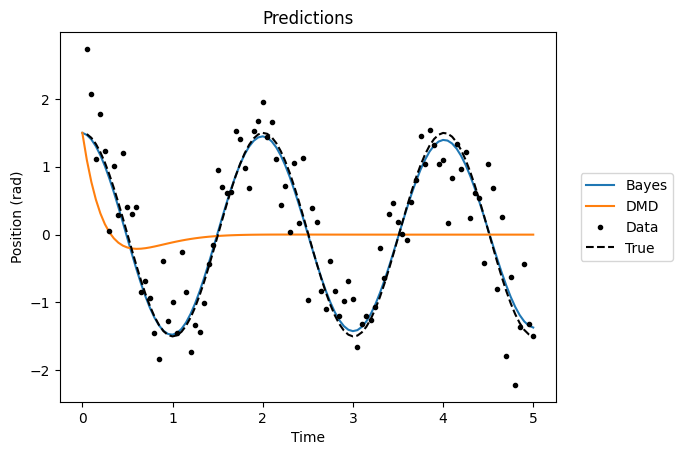

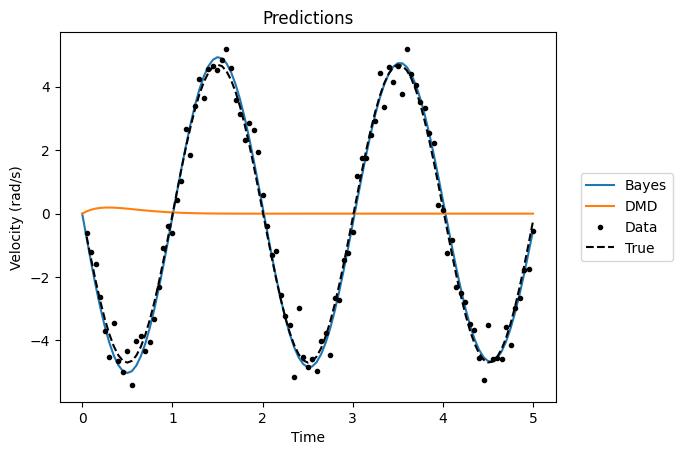

In [142]:
for ii in range(xdim):
    plt.figure()
    plt.plot(t, y_bayes[:,ii], label='Bayes')
    plt.plot(t, y_dmd[:,ii], label='DMD')
    plt.plot(t if measure_y0 else t[1:], data.y[:,ii], 'k.', label='Data')
    plt.plot(t if measure_y0 else t[1:], x_true[:,ii], 'k--', label='True')
    plt.title('Predictions')
    plt.xlabel('Time')
    plt.ylabel(ylabels[ii])
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center right')
plt.show()